In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm

Goal: Use this as testsite for synthetic CNN data generation

In [4]:
GAIN_LIBRARY = {
    '18220_SCA': 1.062, # e- / ADU
    '18248_SCA': 1.021,
    '18266_SCA': 1.056,
    '18274_SCA': 1.038,
    '18275_SCA': 1.074,
    '18282_SCA': 1.031,
    '18283_SCA': 0.999,

    '18273_CASE': 2.6290, # e- / c
    '18546_CASE': 2.5264,
    '18220_CASE': 2.6465,
    '18274_CASE': 2.6025,
    '18266_CASE': 2.6459,
    '18248_CASE': 2.5931,
    '18275_CASE': 2.6140,

    '18282_EuclidFirmware': 1.827, # e- / c
    '18283_EuclidFirmware': 1.776,
}

In [6]:
DATASET_NAME = '18220_SCA'

GAIN = GAIN_LIBRARY['18220_CASE'] # e-/ADU
SATURATION_LEVEL_PXS = (2**16) - 1 # e- / gain

DARK_CURRENT = 0.01
READ_NOISE = 25.0

In [7]:
SATURATION_LEVEL_PXS

65535

In [4]:
CR_ENERGY_e = (100, 5000) # electrons
SNOWBALL_ENERGY_e = (20,000, 70,000) # electrons
RTN_AMP_e = (30, 300) # electrons

In [5]:
def get_saturation_level_elec(gain, saturation_level_pxs):
    """
        * return the saturation level in electrons for a given SCA ID
    """
    saturation_e = saturation_level_pxs * gain

    return saturation_e

In [6]:
SATURATION_LEVEL_ELECS = get_saturation_level_elec(GAIN, SATURATION_LEVEL_PXS)

In [7]:
def generate_baseline_ramp(shape, num_frames, gain, saturation_level_counts, 
                           dark_current, read_noise, extra_gaussian_noise_dn):
    """
    Simulates a baseline up-the-ramp signal (in counts) with dark current and noise.

    Args:
        shape (tuple): (height, width)
        num_frames (int): number of ramp frames
        gain (float): e-/ADU
        saturation_level_counts (float): DN at which saturation occurs
        dark_current (float): electrons per second
        read_noise (float): electrons (std dev)

    Returns:
        np.ndarray: ramp data of shape (num_frames, height, width), in counts
    """
    height, width = shape
    ramps_e = np.zeros((num_frames, height, width), dtype=np.float32)

    for t in tqdm(range(num_frames)):
        signal = dark_current * t + np.random.normal(0, read_noise, size=(height, width))
        ramps_e[t] = signal

    # Convert to counts
    ramps_dn = ramps_e / gain

    # Add extra Gaussian noise in DN (e.g., simulating post-subtraction variance)
    if extra_gaussian_noise_dn > 0:
        ramps_dn += np.random.normal(0, extra_gaussian_noise_dn, size=ramps_dn.shape)

    # Clip to saturation
    ramps_dn = np.clip(ramps_dn, 0, saturation_level_counts)

    return ramps_dn

In [ ]:
def inject_cosmic_ray(ramps, position, frame_idx, 
                      charge_e, gain, saturation_level_counts):
    """
        Inject a cosmic ray as a step function at a specific frame and pixel
        Arguments:
            charge_e (float): total electrons to inject
    """
    charge_dn = charge_e / gain
    
    ramps[frame_idx:, position[0], position[1]] += charge_dn
    
    ramps[:] = np.clip(ramps, 0, saturation_level_counts)

In [9]:
def inject_rtn(ramps, position, high_offset_e, switch_frames, gain, saturation_level_counts):
    """
    Injects a two-level Random Telegraph Noise (RTN) into a specified pixel of the ramp.

    This simulates a signal that toggles between a low and a high state at specified times,
    resembling metastable behavior in pixel output.

    Args:
        ramps (np.ndarray): The data cube of shape (n_reads, height, width).
        position (tuple): (row, col) index of the pixel to modify.
        high_offset_e (float): The amplitude of the high state in electrons.
        switch_frames (list): Frame indices where the RTS toggles between high and low.
        gain (float): Gain in electrons per DN (e⁻/DN).
        saturation_level_counts (float): Maximum allowed DN value to clip the signal to.

    Returns:
        None: The `ramps` array is modified in-place.
    """
    high_offset_dn = high_offset_e / gain
    is_high = False

    for t in range(ramps.shape[0]):
        if t in switch_frames:
            is_high = not is_high

        if is_high:
            ramps[t, position[0], position[1]] += high_offset_dn

    np.clip(ramps, 0, saturation_level_counts, out=ramps)


In [10]:
def inject_snowball(ramps, center, radius, 
                                 core_charge_e, halo_profile_e, gain, 
                                 saturation_level_counts, impact_frame):
    """
    Inject a realistic snowball into a ramp at a specific frame.

    Args:
        ramps (np.ndarray): Ramp cube (n_reads, height, width).
        center (tuple): (y, x) position of snowball.
        radius (float): Radius of saturated core in pixels.
        core_charge_e (float): Charge in e- for saturated core.
        halo_profile_e (callable): Function(distance) -> e- for halo shape.
        gain (float): Detector gain in e-/DN.
        saturation_level_counts (float): Max pixel value (DN).
        impact_frame (int): Frame index when snowball hits.
    """
    h, w = ramps.shape[1:]
    Y, X = np.ogrid[:h, :w]
    distance = np.sqrt((X - center[1])**2 + (Y - center[0])**2)

    core_mask = distance < radius
    halo_mask = (distance >= radius) & (distance < radius + 5)

    core_dn = core_charge_e / gain
    halo_e = halo_profile_e(distance[halo_mask])
    halo_dn = halo_e / gain

    # Inject into the impact frame only
    ramps[impact_frame, core_mask] += core_dn
    ramps[impact_frame, halo_mask] += halo_dn

    # Saturate the core from this point forward
    ramps[impact_frame:, core_mask] = np.clip(ramps[impact_frame:, core_mask],
                                              0, saturation_level_counts)

    ramps[:] = np.clip(ramps, 0, saturation_level_counts)

In [11]:
shape = (2048, 2048)
num_frames = 450 # Not frame difference
ramp = generate_baseline_ramp(
    shape=shape,
    num_frames=num_frames,
    gain=GAIN,
    saturation_level_counts=SATURATION_LEVEL_PXS,
    dark_current= DARK_CURRENT, 
    read_noise= READ_NOISE,
    extra_gaussian_noise_dn = 10.0
)

100%|██████████| 450/450 [00:58<00:00,  7.66it/s]


In [12]:
ramp_diff = ramp[1:] - ramp[0]

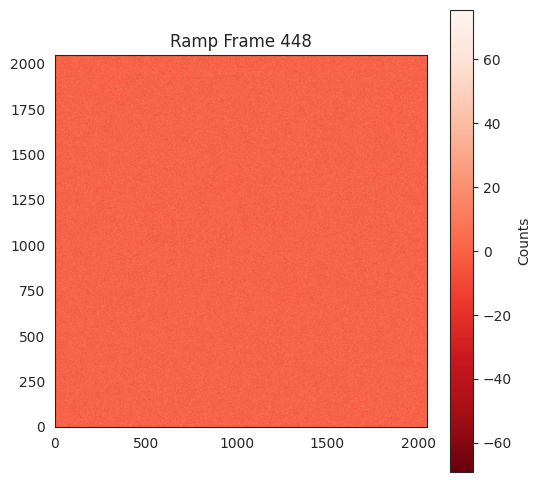

In [13]:
frame_number = 448

sns.set_style('white')
plt.figure(figsize=(6, 6))
plt.imshow(ramp_diff[frame_number], origin='lower', cmap='Reds_r') 
plt.colorbar(label='Counts')
plt.title(f'Ramp Frame {frame_number}')
plt.show()

In [14]:
x, y = 256, 256

In [15]:
inject_cosmic_ray(
    ramps=ramp_diff,
    position = (x, y),
    frame_idx = 120,
    charge_e = 100,  # in electrons
    gain = GAIN,
    saturation_level_counts=SATURATION_LEVEL_PXS
)

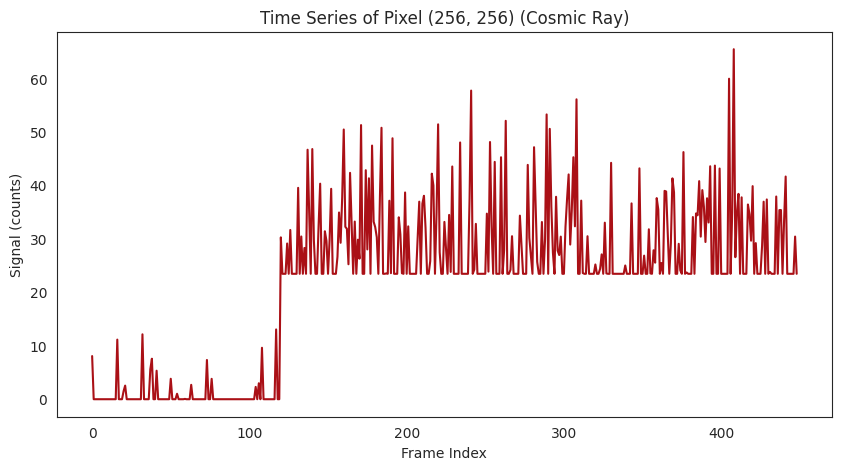

In [16]:
pixel_series = ramp_diff[:, x, y]

# Plot the time series
palette = sns.color_palette('Reds_r', 6)

sns.set_style('white')
plt.figure(figsize=(10, 5))
plt.plot(pixel_series, c = palette[0])
plt.title(f"Time Series of Pixel ({x}, {y}) (Cosmic Ray)")
plt.xlabel("Frame Index")
plt.ylabel("Signal (counts)")
plt.show()

In [17]:
x, y = 111, 111

In [18]:
inject_rtn(
    ramps=ramp_diff,
    position=(x, y),
    high_offset_e=30,  # in electrons
    switch_frames = [50, 83, 209, 300],
    gain=GAIN,
    saturation_level_counts=SATURATION_LEVEL_PXS
)

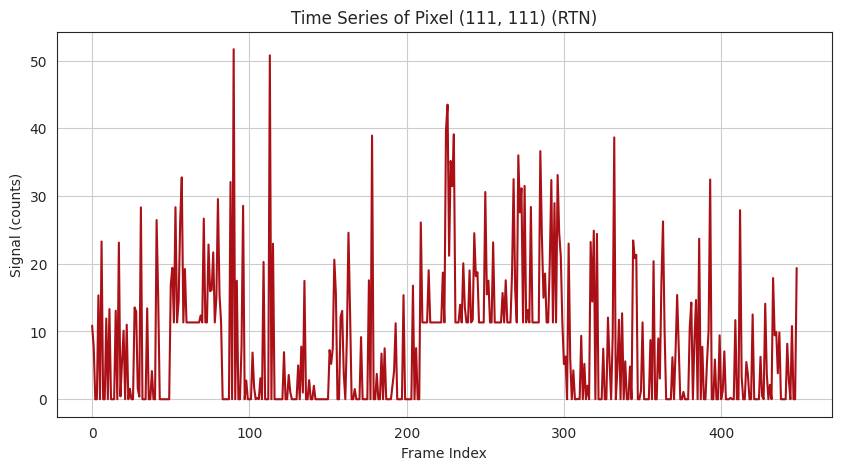

In [19]:
pixel_series = ramp_diff[:, x, y]

# Plot the time series
sns.set_style('white')
plt.figure(figsize=(10, 5))
plt.plot(pixel_series, c = palette[0])
plt.title(f"Time Series of Pixel ({x}, {y}) (RTN)")
plt.xlabel("Frame Index")
plt.ylabel("Signal (counts)")
plt.grid(True)
plt.show()

In [20]:
x, y = 400, 400

In [21]:
def halo_profile(distance):
    return 5000 * np.exp(-0.5 * ((distance - 3)**2) / 2)

inject_snowball(
    ramps=ramp_diff,
    center=(x, y),
    radius=5,
    core_charge_e=65000,
    halo_profile_e=halo_profile,
    gain=GAIN,
    saturation_level_counts=SATURATION_LEVEL_PXS,
    impact_frame=30
)


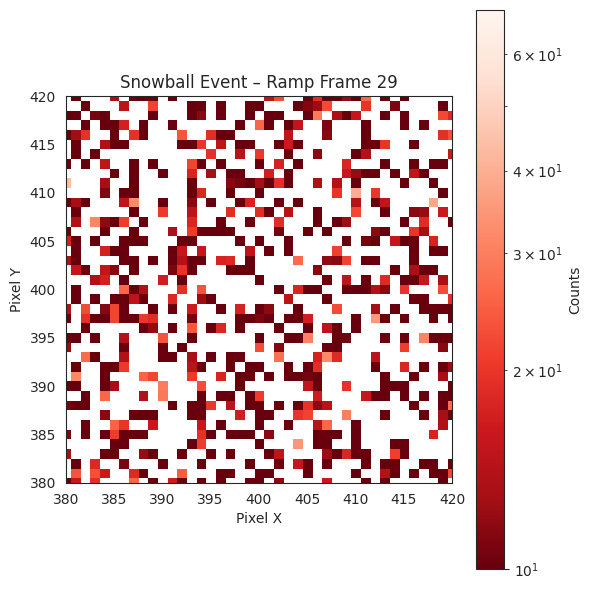

In [22]:
frame_number = 29
curr_ramp = ramp_diff[frame_number]

sns.set_style('white')
plt.figure(figsize=(6, 6))
plt.imshow(curr_ramp, origin='lower', cmap='Reds_r', norm=LogNorm(vmin=10, vmax=curr_ramp.max()))
plt.colorbar(label='Counts')
plt.title(f'Snowball Event – Ramp Frame {frame_number}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.xlim(x - 20, x + 20)
plt.ylim(y - 20, y + 20)
plt.tight_layout()
plt.show()

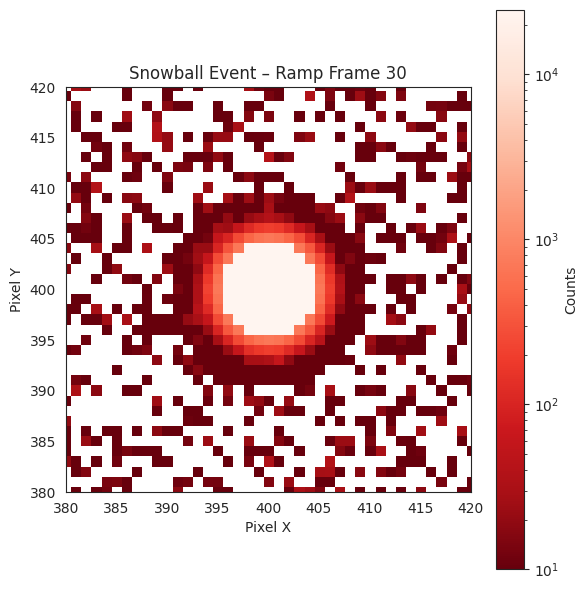

In [23]:
frame_number = 30
curr_ramp = ramp_diff[frame_number]

sns.set_style('white')
plt.figure(figsize=(6, 6))
plt.imshow(curr_ramp, origin='lower', cmap='Reds_r', norm=LogNorm(vmin=10, vmax=curr_ramp.max()))
plt.colorbar(label='Counts')
plt.title(f'Snowball Event – Ramp Frame {frame_number}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.xlim(x - 20, x + 20)
plt.ylim(y - 20, y + 20)
plt.tight_layout()
plt.show()